## Mauna Loa 

In this notebook it is shown how to apply Gaussian Processes for Regression using scikit learn library. The data set consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2017. The objective is to model the CO2 concentration as a function of the time t. Since some of the values of 1958 are missing they were dropped.

In [3]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.datasets import fetch_mldata

data = np.genfromtxt('files/maunaloa2017.txt',delimiter='')
data1=data[:,2:4]
data1=data1[10:] #We drop the values of 1958
print data1[0]   #The first observation is provided
print data1.shape

[ 1959.042   315.62 ]
(698, 2)


The data from 1959 to 2017 contains 5 missing values that, instead of dropping them, were replaced considering the mean of the year and historical values of the same month in order to provide a good aproximation.

In [3]:
data1.shape #Els valor -99.99 els subtituim per la mitja de l'any i valors similars passats
data1[61][1]=320.1
data1[62][1]=320.6
data1[63][1]=321.8
data1[203][1]=331.16
data1[303][1]=347.08

The data is separated between the training and the test set. The training set contains the concentration of CO2 from 1959 to 2003, and the test set the remaining. Below all the information in the training set is plotted. Note the rising trend and seasonal variations. 

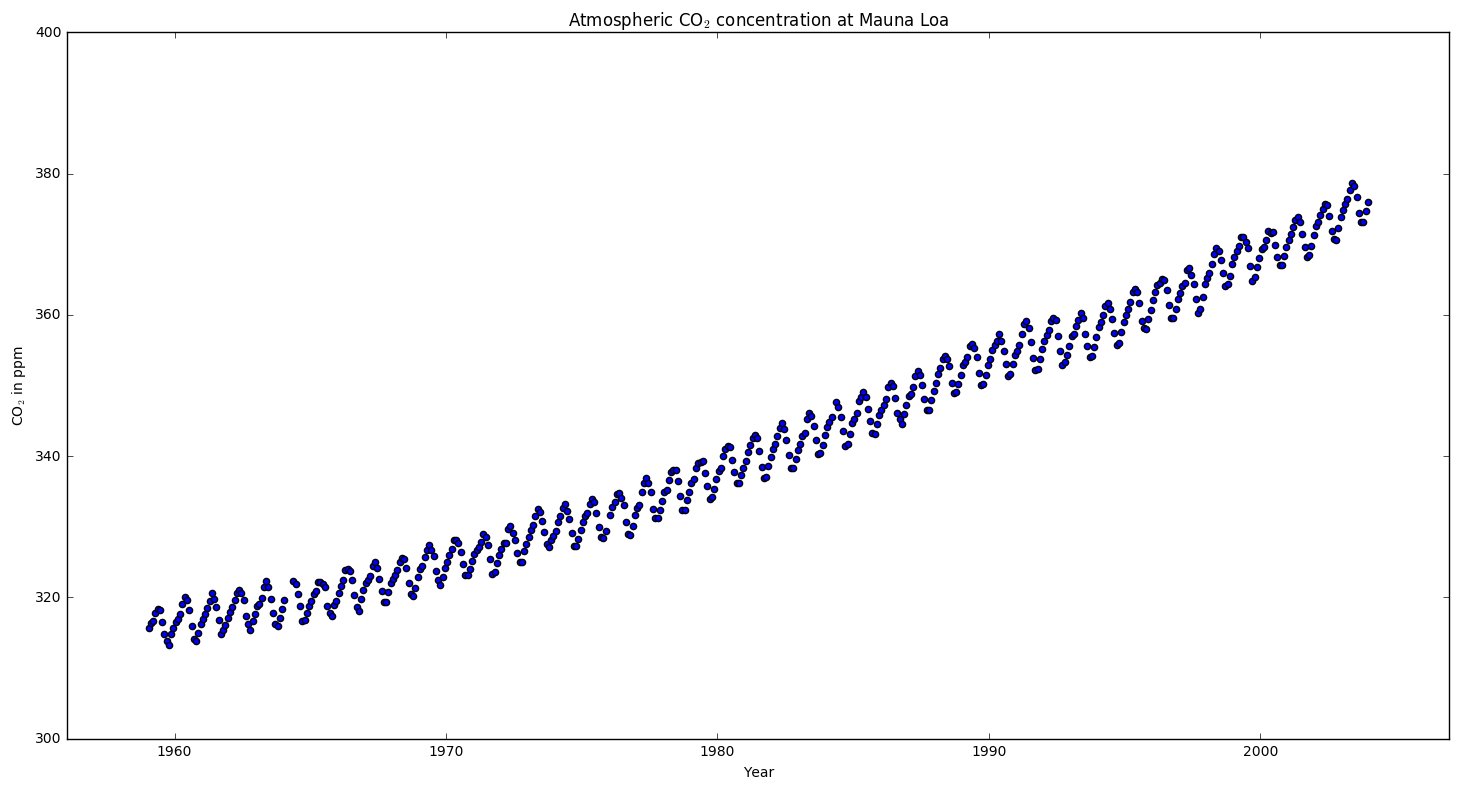

In [4]:
import matplotlib.pyplot as plt
X=data1[:540,0]# conté els anys fins al 2003
y=data1[:540, 1]# conté les concentracions de CO2 fins l'any 2003

plt.figure(figsize=(15,8))
plt.scatter(X, y , c='b')
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.xlim(X.min()-3, X.max()+3)
plt.ylim(300,400)
plt.show()

We transform the lists that contains the decimal expression of the years and the CO2 concentrations into an arrays.

In [5]:
X1array= np.asarray(X)[:,None] #Transformem els anys que eren una llista en un array
Xcon=np.asarray(y)[:,None]  #Concentració de Co2
print Xcon.shape

(540, 1)


In order to capture all the propierties of our data we construct an additive covariance function, and we initialize the values of the hyperparameters to reasonable approximations. We optimize the marginal likelihood using a conjugate gradient optimitzer as BFGS algorithm.

In [6]:
# Kernel with parameters randomly initialized 
k1 = 50.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
k2 = 1**2 * RBF(length_scale=30.0) \
    * ExpSineSquared(length_scale=1, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.5**2 \
    * RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4


gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=2, normalize_y=True)

In order to improve the performance we use k-cross validation with k=3 and in each of these runnings the hyperparameters of the covariance functions fits better with the data.

In [7]:
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics
acc = np.zeros((3,))
acc1 = np.zeros((3,))
i=0
kf=cross_validation.KFold(n=X1array.shape[0], n_folds=3, shuffle=False, random_state=0)
print kf
#We will build the predicted y from the partial predictions on the test of each of the folds
yhat = Xcon.copy()
for train_index, test_index in kf:
    X_train, X_test = X1array[train_index], X1array[test_index]
    y_train, y_test = Xcon[train_index], Xcon[test_index]
    gp.fit(X_train,y_train)
    yhat[test_index]= gp.predict(X_test)
    acc[i] = metrics.mean_squared_error(y_test, yhat[test_index])
    acc1[i] = metrics.r2_score(y_test, yhat[test_index])
    print ' Mean squared error', acc[i]  
    print 'R^2 coefficient', acc1[i]
    i=i+1
print '\n Mean accuracy: '+ str(np.mean(acc))
print 'Mean R^2 coefficient' + str(np.mean(acc1))

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


sklearn.cross_validation.KFold(n=540, n_folds=3, shuffle=False, random_state=0)
 Mean squared error 54.6138656104
R^2 coefficient -1.84809762407
 Mean squared error 0.208232424126
R^2 coefficient 0.995569472063
 Mean squared error 6.97478153275
R^2 coefficient 0.869394079051

 Mean accuracy: 20.5989598558
Mean R^2 coefficient0.00562197568076


The final log-marginal likelihhod after the optimitzation process is -77.146. The values of the hyperparameters are shown below. 

In [8]:
print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 65**2 * RBF(length_scale=55.9) + 3.49**2 * RBF(length_scale=239) * ExpSineSquared(length_scale=1.61, periodicity=1) + 0.327**2 * RationalQuadratic(alpha=15.6, length_scale=0.727) + 0.185**2 * RBF(length_scale=0.156) + WhiteKernel(noise_level=0.0399)
Log-marginal-likelihood: -77.146


Finally in order to determine the precision of our model we predict the CO2 concentrations for the periods between 2004 and 2017. The R^{2} coefficient is 0.9455, meaning, that the predicitions are quite accurate.

In [11]:
from sklearn import metrics
y_pred, sigma = gp.predict(data1[540:,0].reshape(-1,1), return_std=True)
acc2 = metrics.r2_score(data1[540:,1].reshape(-1,1),y_pred.reshape(-1,1))
print acc2


0.945508735042


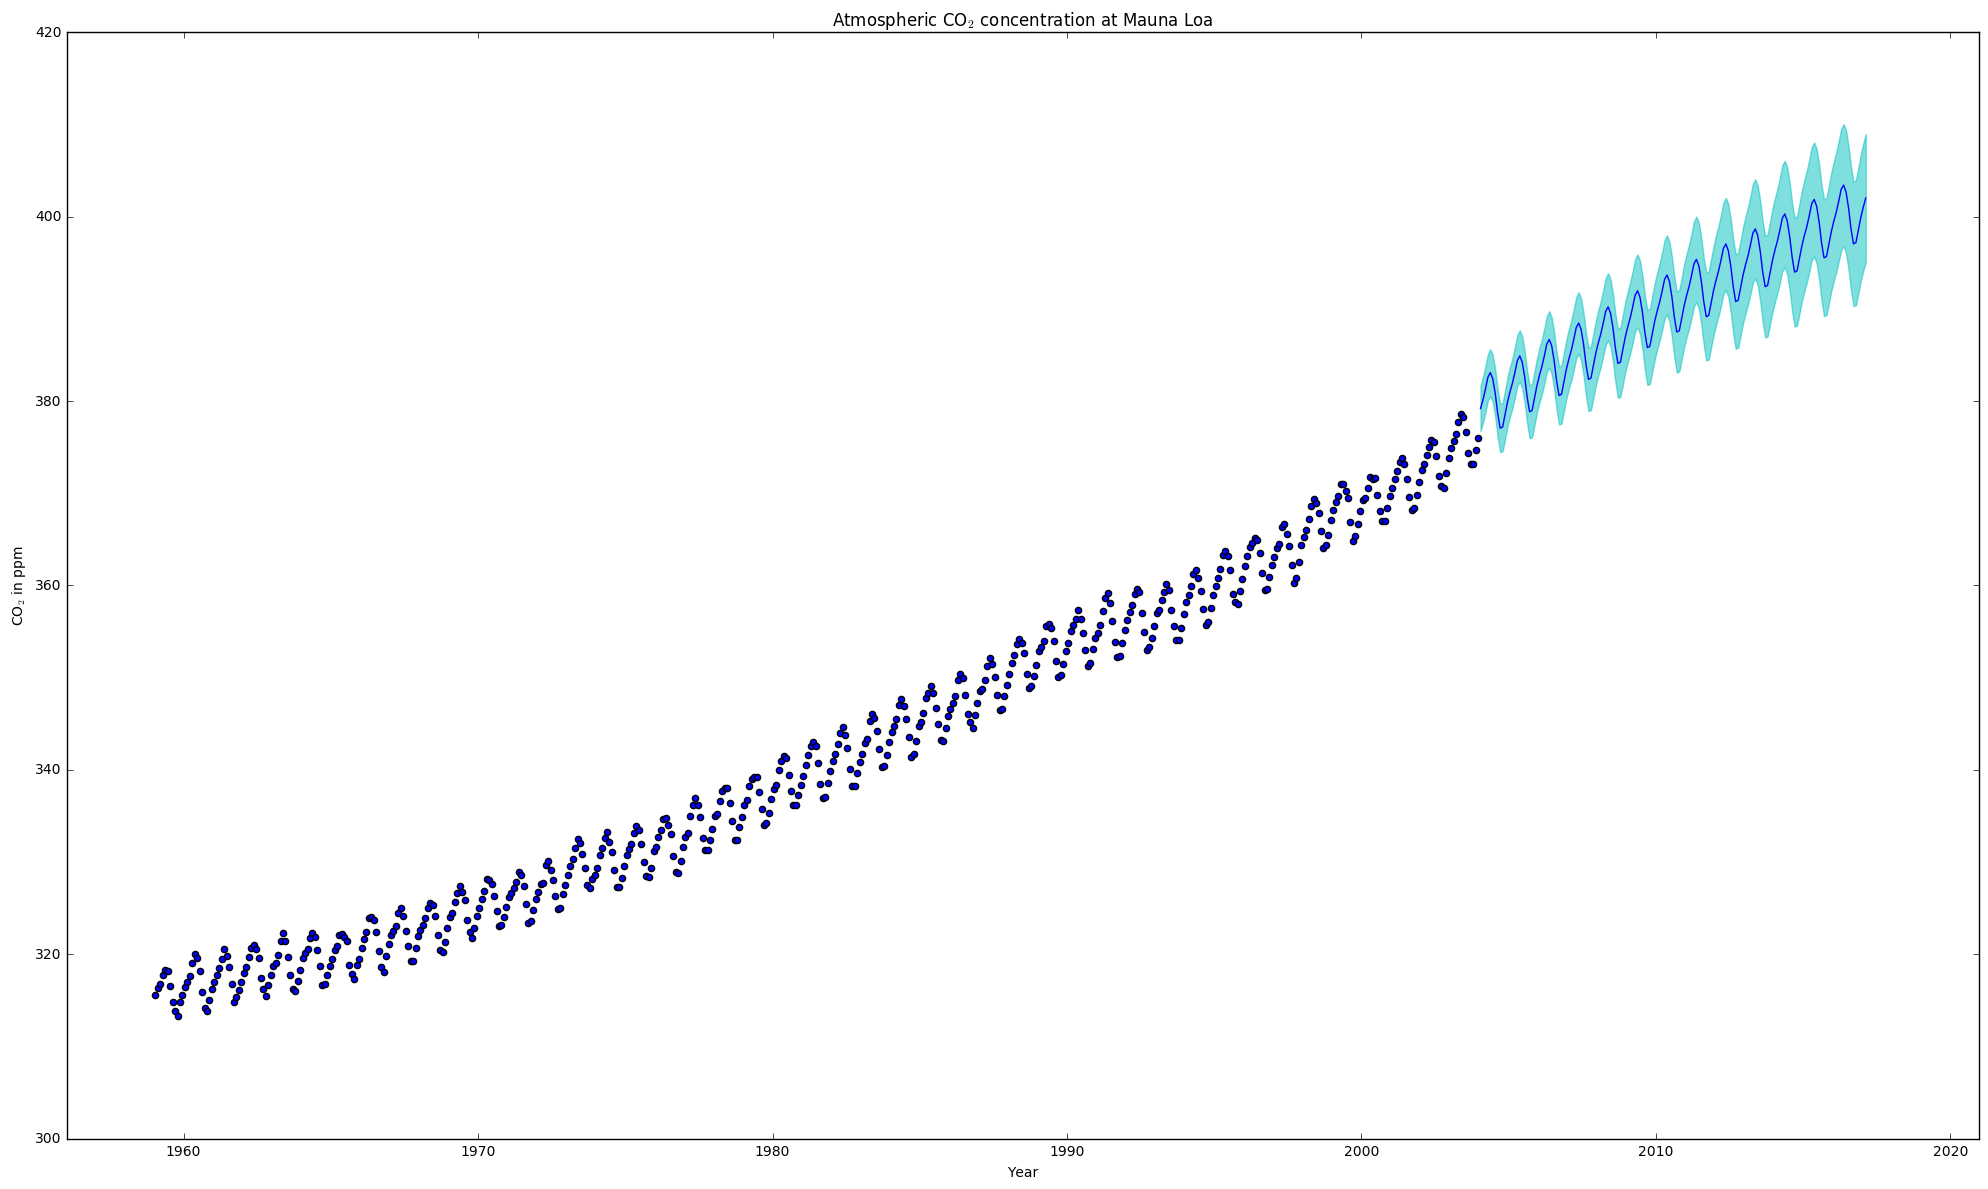

In [10]:
plt.figure(figsize=(20,12))
plt.scatter(X, y , c='b')
plt.plot(data1[540:,0], y_pred)
plt.fill_between(data1[540:,0], y_pred[:,0] - 1.96*sigma, y_pred[:,0] + 1.96*sigma,alpha=0.5, color='c')
plt.xlim(X.min()-3, X.max()+17)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

## Decompisition of the kernel

We show the individual contribution of each kernel

In [11]:
#Descomposem les components de la serie temporal
Xnew=[1958+float(i)/12 for i in range(59*12)] 
Xnew=np.asarray(Xnew)[:,None]

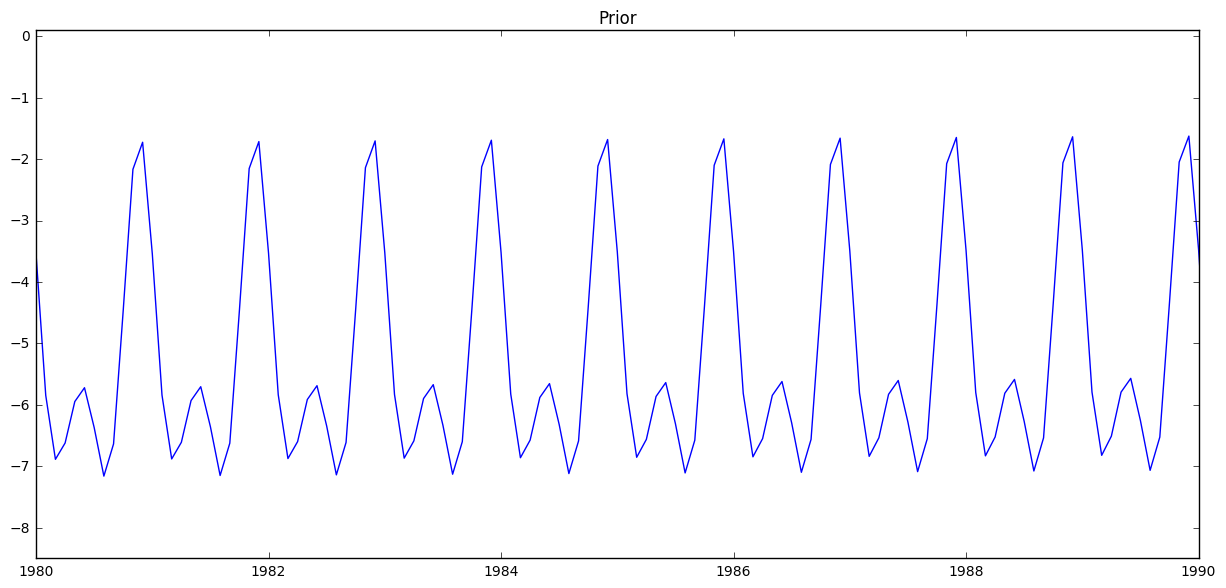

In [21]:
#Component estacional: SE*PEr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = 3.49**2 * RBF(length_scale=239) * ExpSineSquared(length_scale=1.61, periodicity=1)
gp = GaussianProcessRegressor(kernel=kernels)
# Plot prior
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
X_ = Xnew
y_samples = gp.sample_y(X_,1)
plt.plot(X_, y_samples, lw=1)
plt.xlim(1980, 1990)
plt.ylim(-8.5, 0.1)
plt.title("Prior", fontsize=12)
plt.show()

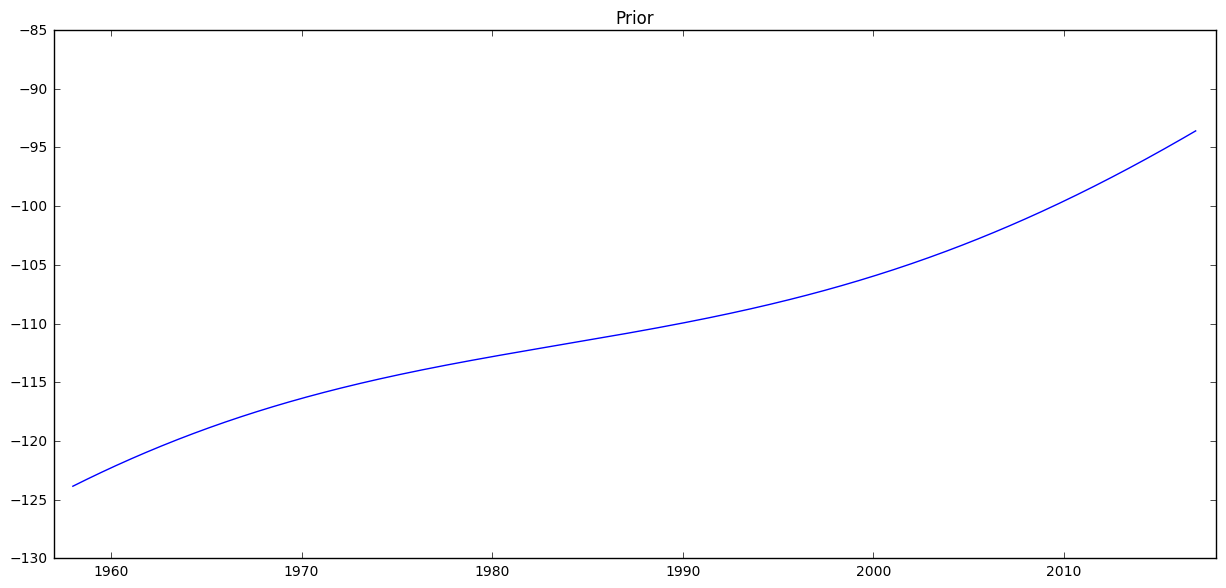

In [18]:
#Long term trend:SE

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)



kernels = 65**2 * RBF(length_scale=55.9) 
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernels)
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
X_ = Xnew
y_samples = gp.sample_y(X_, 1)
plt.plot(X_, y_samples, lw=1)
plt.xlim(1957, 2018)
plt.ylim(-130, -85)
plt.title("Prior", fontsize=12)
plt.show()

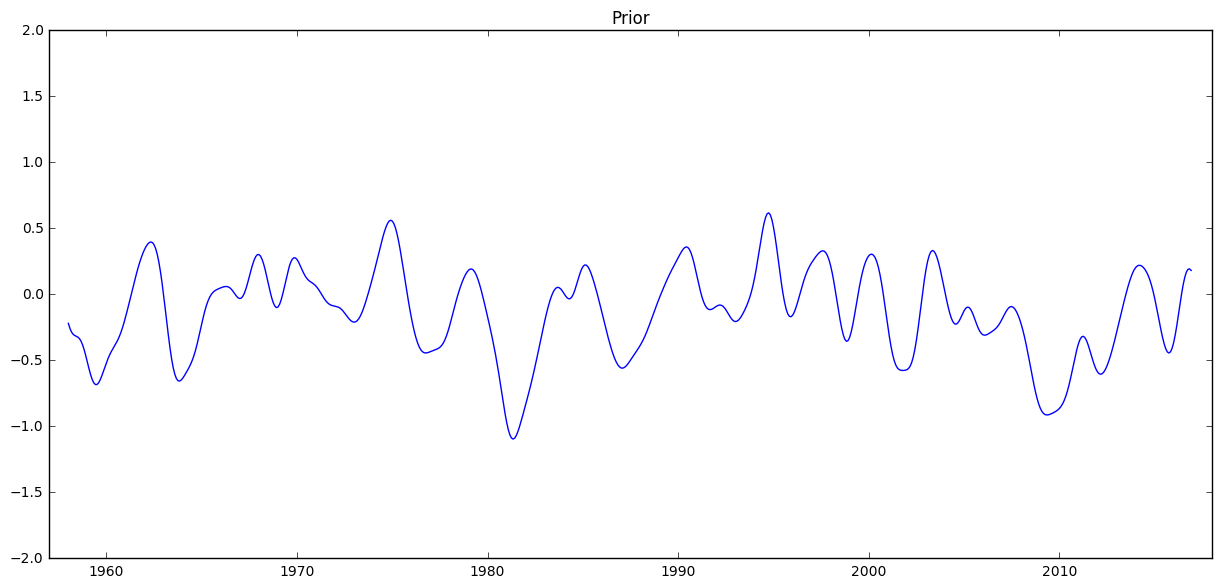

In [14]:
#Medium-term deviation
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)



kernels = 0.327**2 * RationalQuadratic(alpha=15.6, length_scale=0.727) 
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernels)
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
X_ = Xnew
y_samples = gp.sample_y(X_, 1)
plt.plot(X_, y_samples, lw=1)
plt.xlim(1957, 2018)
plt.ylim(-2, 2)
plt.title("Prior", fontsize=12)
plt.show()


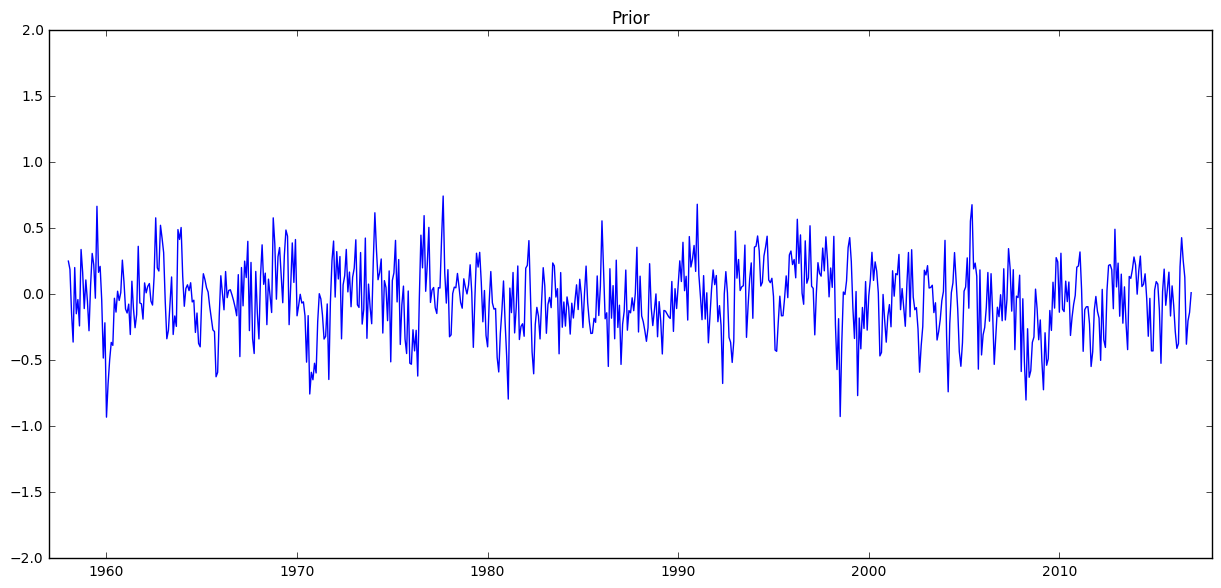

In [15]:
#Noise: SE+WN
0.26**2 * RBF(length_scale=0.121) + WhiteKernel(noise_level=0.0664)
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)



kernels = 0.185**2 * RBF(length_scale=0.156) + WhiteKernel(noise_level=0.0399)
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernels)
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
X_ = Xnew
y_samples = gp.sample_y(X_, 1)
plt.plot(X_, y_samples, lw=1)
plt.xlim(1957, 2018)
plt.ylim(-2, 2)
plt.title("Prior", fontsize=12)
plt.show()